In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import re
import string
from keras.callbacks import ReduceLROnPlateau

In [2]:
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = 0.9
max_length=25

In [3]:
df_offensive=pd.read_csv("labeled_data.csv")

In [4]:
df_offensive

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df_offensive.shape

(24783, 7)

In [5]:
df_offensive.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)
df_offensive.head(10)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,1,""" &amp; you might not get ya bitch back &amp; ..."
9,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [6]:
def clean_text(sentence):
    sentence = sentence.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    sentence = pattern.sub('', sentence)
    sentence = " ".join(filter(lambda x:x[0]!='@', sentence.split()))
    emo = re.compile("["
                           u"\U0001F600-\U0001FFFF"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    sentence = emo.sub(r'', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)        
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence) 
    sentence = re.sub(r"\'ll", " will", sentence)  
    sentence = re.sub(r"\'ve", " have", sentence)  
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"won't", "will not",sentence)
    sentence = re.sub(r"don't", "do not", sentence)
    sentence = re.sub(r"did't", "did not", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"couldn't", "could not", sentence)
    sentence = re.sub(r"have't", "have not", sentence)
    sentence = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", sentence)
    return sentence

In [7]:
def CleanTokenize(df):
    head_lines = list()
    lines = df["tweet"].values.tolist()

    for line in lines:
        line = clean_text(line)
        tokens = word_tokenize(line)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

sentences = CleanTokenize(df_offensive)
sentences[0:10]

[['rt',
  'woman',
  'shouldnt',
  'complain',
  'cleaning',
  'house',
  'amp',
  'man',
  'always',
  'take',
  'trash'],
 ['rt',
  'boy',
  'dats',
  'coldtyga',
  'dwn',
  'bad',
  'cuffin',
  'dat',
  'hoe',
  'place'],
 ['rt',
  'dawg',
  'rt',
  'ever',
  'fuck',
  'bitch',
  'start',
  'cry',
  'confused',
  'shit'],
 ['rt', 'look', 'like', 'tranny'],
 ['rt',
  'shit',
  'hear',
  'might',
  'true',
  'might',
  'faker',
  'bitch',
  'told',
  'ya'],
 ['tmadisonx',
  'shit',
  'blows',
  'meclaim',
  'faithful',
  'somebody',
  'still',
  'fucking',
  'hoes'],
 ['brighterdays',
  'sit',
  'hate',
  'another',
  'bitch',
  'got',
  'much',
  'shit',
  'going'],
 ['cause', 'tired', 'big', 'bitches', 'coming', 'us', 'skinny'],
 ['amp', 'might', 'get', 'ya', 'bitch', 'back', 'amp', 'thats'],
 ['hobbies', 'include', 'fighting', 'mariam', 'bitch']]

In [8]:
split=0.1
training_size = int(split*len(sentences))
labels = df_offensive['class'].values
train_sentences=sentences[0:training_size]
test_sentences=sentences[training_size:]
train_labels=labels[0:training_size]
test_labels=labels[training_size:]

In [9]:
oov_tok = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index
vocab_size=len(word_index)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded=pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded=pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')
train_labels=np.array(train_labels)
test_labels=np.array(test_labels)

In [10]:
embeddings_index = {}
embedding_dim = 100
f = open(('glove.6B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

4355


In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                    output_dim=embedding_matrix.shape[1],
                                    weights = [embedding_matrix],
                                    input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                                             return_sequences = True,
                                                             recurrent_dropout=0.2)))
model.add(tf.keras.layers.GlobalMaxPool1D()) 
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation = "relu")) 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation = "relu")) 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           559800    
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          234496    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_labels),train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

C:\Users\dgopa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[2 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [14]:
epoch_count=20
batch_size= 128
history = model.fit(
    train_padded, 
    train_labels, 
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (test_padded,test_labels),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight=class_weight
)

Epoch 1/20
20/20 [==============================] - 22s 681ms/step - loss: 1.7941 - accuracy: 0.4076 - val_loss: 1.1069 - val_accuracy: 0.0983 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 12s 640ms/step - loss: 1.4050 - accuracy: 0.4326 - val_loss: 1.0726 - val_accuracy: 0.3096 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 13s 662ms/step - loss: 1.2354 - accuracy: 0.4661 - val_loss: 1.0434 - val_accuracy: 0.5364 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 12s 635ms/step - loss: 1.1531 - accuracy: 0.5335 - val_loss: 1.0196 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 5/20
20/20 [==============================] - 12s 615ms/step - loss: 1.0128 - accuracy: 0.5658 - val_loss: 1.0039 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 6/20
20/20 [==============================] - 12s 638ms/step - loss: 0.8792 - accuracy: 0.5912 - val_loss: 0.9774 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 7/20
20/20 [==============================] - 12s 624ms/st

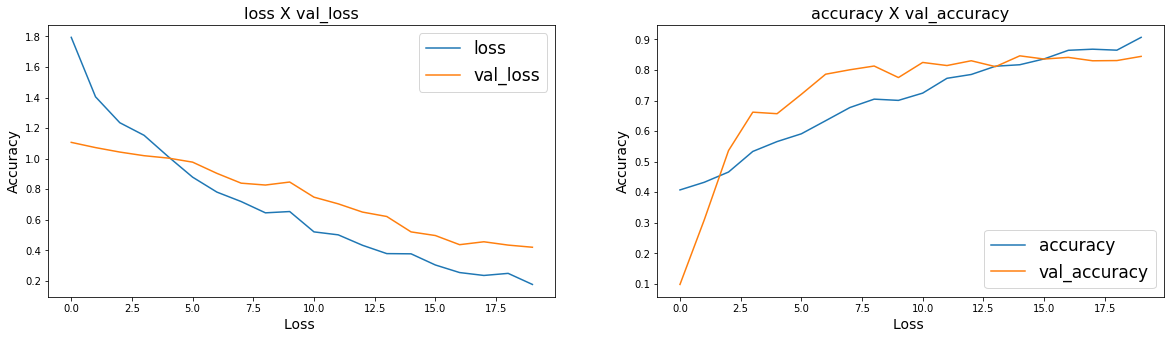

In [15]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=17)
        ax[idx].set_xlabel('Loss ',fontsize=14)
        ax[idx].set_ylabel('Accuracy',fontsize=14)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [17]:
!pip install Tweepy

In [18]:
def printtweetdata(n, ith_tweet):
        print()
        print(f"Tweet {n}:")
        print(f"Username:{ith_tweet[0]}")
        print(f"Description:{ith_tweet[1]}")
        print(f"Location:{ith_tweet[2]}")
        print(f"Following Count:{ith_tweet[3]}")
        print(f"Follower Count:{ith_tweet[4]}")
        print(f"Total Tweets:{ith_tweet[5]}")
        print(f"Retweet Count:{ith_tweet[6]}")
        print(f"Tweet Text:{ith_tweet[7]}")
        print(f"Hashtags Used:{ith_tweet[8]}")

In [19]:
def scrape(words, date_since, numtweet):
        db = pd.DataFrame(columns=['username',
                                   'description',
                                   'location',
                                   'following',
                                   'followers',
                                   'totaltweets',
                                   'retweetcount',
                                   'text',
                                   'hashtags'])
        tweets = tweepy.Cursor(api.search_tweets,
                               words, lang="en",
                               since_id=date_since,
                               tweet_mode='extended').items(numtweet)
        list_tweets = [tweet for tweet in tweets]
        i = 1
        for tweet in list_tweets:
                username = tweet.user.screen_name
                description = tweet.user.description
                location = tweet.user.location
                following = tweet.user.friends_count
                followers = tweet.user.followers_count
                totaltweets = tweet.user.statuses_count
                retweetcount = tweet.retweet_count
                hashtags = tweet.entities['hashtags']
                try:
                        text = tweet.retweeted_status.full_text
                except AttributeError:
                        text = tweet.full_text
                hashtext = list()
                for j in range(0, len(hashtags)):
                        hashtext.append(hashtags[j]['text'])
                ith_tweet = [username, description,
                             location, following,
                             followers, totaltweets,
                             retweetcount, text, hashtext]
                db.loc[len(db)] = ith_tweet
                printtweetdata(i, ith_tweet)
                i = i+1
        filename = 'scraped_tweets.csv'
        db.to_csv(filename)

In [26]:
import tweepy
consumer_key = "D5QKTDSY7LnB0HrZXEquBJIpA"
consumer_secret = "za3WphGqvr0rgUL69ocyHELavCnKAfXfjhA54RV8jCL2lWa1w4"
access_key = "1226379496489504769-MS9QIlv7rWJWDvI4awzDMrCNSYFdHh"
access_secret = "GP5rFSbjeCZZgesgss8OEXz0yrRpROuyPzFNTYJvsyp7K"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)
print("Enter Twitter HashTag to search for")
words = input()
print("Enter Date since The Tweets are required in yyyy-mm--dd")
date_since = input()
numtweet = 10000
scrape(words, date_since, numtweet)
print('Scraping has completed!')

Enter Twitter HashTag to search for
agnipath
Enter Date since The Tweets are required in yyyy-mm--dd
2022-07--04


TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

In [21]:
def predict(s):
    x_final = pd.DataFrame({"tweet":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    classes = np.argmax(pred, axis = 1)
    #print(classes)
    return classes

In [22]:
df=pd.read_csv("scraped_tweets.csv")
df['text']

0     Army Agniveer Notification released for Septem...
1     Jai Ho 🇮🇳💪\n7,49,899 applications received for...
2     Congress leader P Chidambaram contends that IA...
3     Agnipath Recruitment Scheme 2022: IAF receives...
4     Congress leader P Chidambaram contends that IA...
                            ...                        
95    Brig (Retd) Vivek Chhatre (@vivekchats), share...
96    Congress Spokesperson , Alok Sharma brilliantl...
97    Jai Ho 🇮🇳💪\n7,49,899 applications received for...
98    Aspiring IAF Airman Lucky had two surgeries to...
99    Congress Spokesperson , Alok Sharma brilliantl...
Name: text, Length: 100, dtype: object

In [23]:
text=df['text'].values.tolist()
h=list()
o=list()
n=list()
for i in text:
    t=predict(i)
    i=clean_text(i)
    print(t)
    if t==0:
        h.append(i)
    elif t==2:
        n.append(i)
    else:
        o.append(i)

1/1 [==============================] - 0s 357ms/step
[2]
1/1 [==============================] - 0s 18ms/step
[2]
1/1 [==============================] - 0s 16ms/step
[1]
1/1 [==============================] - 0s 18ms/step
[2]
1/1 [==============================] - 0s 17ms/step
[1]
1/1 [==============================] - 0s 17ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[2]
1/1 [==============================] - 0s 17ms/step
[1]
1/1 [==============================] - 0s 18ms/step
[2]
1/1 [==============================] - 0s 17ms/step
[2]
1/1 [==============================] - 0s 16ms/step
[2]
1/1 [==============================] - 0s 17ms/step
[1]
1/1 [==============================] - 0s 16ms/step
[0]
1/1 [==============================] - 0s 22ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[2]
1/1 [==============================] - 0s 17ms/step
[2]
1/1 [==============================] - 0s 18ms/

In [24]:
print(len(h))
print(len(o))
print(len(n))

1
15
84


In [25]:
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))
h=unique(h)
o=unique(o)

['nationalcadetcorps agnipath bharatkeagniveer serve the nation as agniveer under agnipath scheme 12obn']
['congress leader p chidambaram contends that iaf receiving 75 lakh applications under agnipath scheme is not indicative of its popularity says right conclusion to be drawn from it is that unemployment situation is so extreme that desperate youths are willing to take any job'
 'even if one person applies for this sadistic exploitative recruitment it is saddening  colonial rulers taking tamilians as plantation tamils across the world was better than this agnipath'
 'guys i do not think with all this agnipath scheme nupur sharma controversy and all that going with bjp modiji is already preoccupied and will not listen to us at this moment 13 pmohelpneetugaspirants modijideferneetug modijiextendneetug candlemarchforneetug'
 'hello india this incompetent govt intentionally brought agnipath scheme at a time when there is massive unemployment n poverty it is not helping the youth in stead